## KAZR spectra reader

Are there Py-ART modules that work with VPR spectra data? The modules will need to read the sparse matrices, de-alias the spectra, and then estimate spectrum noise level, integration limits, and calculate the moments (including velocity spectrum skewness). 

An example spectra file would be: KAZR spectra from SGP, GE mode, 20-May-2011: sgpkazrspeccmaskgecopolC1.a0.20110520.1300004.cdf 

In [451]:
import xarray
import pyart
import warnings
import datetime
import time
from netCDF4 import Dataset
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-07-09 16:47:45.466000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [63]:
data_path = 'data/sgpkazrspeccmaskgecopolC1.a0.20110520.130004.cdf'
spectra_ds = xarray.open_dataset(data_path)
print(spectra_ds)

<xarray.Dataset>
Dimensions:        (numspectra: 322945, range: 582, speclength: 256, time: 975)
Coordinates:
  * range          (range) float32 100.679245 130.6585 160.63774 190.61699 ...
Dimensions without coordinates: numspectra, speclength, time
Data variables:
    base_time      timedelta64[ns] ...
    time_offset    (time) float64 ...
    velocity_bins  (speclength) float32 ...
    locator_mask   (time, range) float64 ...
    spectra        (numspectra, speclength) float32 ...
Attributes:
    attenuation:                  4.00 dB
    cal_constant:                -21.7945 dB
    clutter_filter_len:             0
    fft_len:                      256
    num_spectral_averages:        20
    nyquist_velocity:             5.9634 m/s
    processing_mode:             2
    pulse_repetition_frequency:   2771.31 Hz
    pulse_width:                   300 ns
    radar_constant_offset_flag:  0
    radar_constant_offset:         0.0000 dB
    radar_operating_frequency:    34.8300 Hz
    rx_n

C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-07-09 09:49:40.074000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\xarray\coding\variables.py:135: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


## Get spectra and 0, 1th moments

In [398]:
def get_spectra(ds, time):
    the_spectra_locs = ds.locator_mask.sel(time=time).values
    the_spectra_loc = np.zeros((len(the_spectra_locs), len(ds.speclength.values)))
    i = 0
    for locs in the_spectra_locs:
        if(locs is not -9999.0):
            the_spectra_loc[i,:] = ds.spectra.values[int(locs),:]
        else:
            the_spectra_loc[i,:] = np.nan*np.ones(len(ds.speclength.values))
        i += 1
    return the_spectra_loc

    
def get_noise_floor_and_limits(the_spectra, avg_window=1):
    lin_spectra = 10**(the_spectra/10.0)
    if(avg_window > 1):
        for i in range(lin_spectra.shape[0]):
            lin_spectra[i] = np.convolve(lin_spectra[i], np.ones((avg_window))/avg_window,
                                      mode='same')
            
    noise_floor = pyart.util.estimate_noise_hs74(lin_spectra, navg=avg_window)
    noise_floor_thresh = 10*np.log10(noise_floor[0])

    spectra = 10*np.log10(lin_spectra - noise_floor[0])
    spectra[lin_spectra < 0] = np.nan
    left = np.nan*np.ones(spectra.shape[0])
    right = np.nan*np.ones(spectra.shape[0])
    for i in range(spectra.shape[0]):
        above_floor = np.where(np.isfinite(spectra[i]))
        try:
            peak_loc = np.nanargmax(spectra[i])
            j = peak_loc
            while(np.isfinite(spectra[i,j]) and j > 0):
                j = j - 1
            
            left[i] = j
            j = peak_loc
            while(np.isfinite(spectra[i,j]) and j < spectra.shape[1]-1):
                j = j + 1
            right[i] = j            
        except(ValueError):
            left[i] = np.nan
            right[i] = np.nan
        
    spectra = np.ma.masked_where(np.isnan(spectra), spectra)
    return noise_floor_thresh, left, right, spectra

def get_reflectivity(spectra, bins, wavelength, left, right):
    if(np.isnan(left) or np.isnan(right)):
        return np.nan
    spectra_linear = 10**(spectra/10)
    radar_constant = 1e18*wavelength**4/(0.93*np.pi**5)
    spec_med = radar_constant*(spectra_linear[:-1]+spectra_linear[1:])/2
    above_floor = np.arange(left, right, 1, dtype='int')
    diffs = np.diff(bins)
    bins_med = (bins[:-1]+bins[1:])/2.0
    ref = np.nansum(spec_med[above_floor]*diffs[above_floor])
    return 10*np.log10(ref)

def get_mean_velocity(spectra, bins, wavelength, left, right):
    # Get bins > noise flood
    if(np.isnan(left) or np.isnan(right)):
        return np.nan
    ref = 10**(get_reflectivity(spectra, bins, wavelength, left, right)/10)
    spectra_linear = 10**(spectra/10)
    radar_constant = 1e18*wavelength**4/(0.93*np.pi**5)
    spec_med = radar_constant*(spectra_linear[:-1]+spectra_linear[1:])/2
    above_floor = np.arange(left, right, 1, dtype='int')
    diffs = np.diff(bins)
    bins_med = (bins[:-1]+bins[1:])/2.0
    mean_vel = np.nansum(spec_med[above_floor]*bins_med[above_floor]*diffs[above_floor])/ref
    return mean_vel

# Takes in noise subtracted spectra   
def dealias_spectra(the_spectra, vel_bins, wavelength, left, right):
    # Calculate mean of gate before to decide whether to dealias left or right side 
    # of spectrum - continuity check!
    mean_vel = [get_mean_velocity(the_spectra[i], vel_bins, wavelength, left[i], right[i]) 
                for i in range(the_spectra.shape[0])]
    mean_vel = np.array(mean_vel)
    valid_vel = np.where(mean_vel > -9999.0)[0]
    new_bins = np.concatenate([vel_bins-2*vel_bins[-1], vel_bins, vel_bins+2*vel_bins[-1]])
    
    # Expand interval to -3Vn, 3Vn
    n_pts = len(vel_bins)
    new_spectra = np.nan*np.ones((the_spectra.shape[0], n_pts*3))
    dealiased_already = np.zeros(the_spectra.shape[0])
    # Test for aliasing - look for tail on both right interval and left interval
    for i in range(the_spectra.shape[0]):
        # First test to dealias: peaks on both sides
        # Second test: Discontinuity in velocities
        if(i > 1):
            second_vel = mean_vel[i-1]
        else:
            second_vel = mean_vel[i]
        if((np.isfinite(the_spectra[i,0]) and np.isfinite(the_spectra[i,-1]))):
            noise_region = np.where(np.isnan(the_spectra[i]))[0]
            
            if(second_vel < 0):
                right_tail_len = int(the_spectra.shape[1]-noise_region[-1])
                new_spectra[i,n_pts-right_tail_len:n_pts] = the_spectra[i, n_pts-right_tail_len:n_pts]
                new_spectra[i,n_pts:2*n_pts-right_tail_len] = the_spectra[i, 0:n_pts-right_tail_len]
            else:
                left_tail_len = int(noise_region[0])
                new_spectra[i,2*n_pts:2*n_pts+left_tail_len] = the_spectra[i, 0:left_tail_len]
                new_spectra[i,n_pts+left_tail_len:2*n_pts] = the_spectra[i, left_tail_len:]
            dealiased_already[i] = 1
        
    
    # Do a second check for continuity
    mean_vel = [get_mean_velocity(new_spectra[i], new_bins, wavelength, left[i], right[i]) 
                for i in range(new_spectra.shape[0])]
    for i in range(new_spectra.shape[0]):
        # First test to dealias: peaks on both sides
        # Second test: Discontinuity in velocities
        if(i > 1):
            second_vel = mean_vel[i-1]
        else:
            second_vel = mean_vel[i]
            
        # Discontinuity = more than 1 Nyquist switch in mean velocity     
        if(abs(mean_vel[i]-second_vel) > vel_bins[-1] and dealiased_already[i] == 0):
            noise_region = np.where(np.isnan(the_spectra[i]))[0]
            if(mean_vel[i] > 0):
                right_tail_len = int(the_spectra.shape[1]-noise_region[-1])
                new_spectra[i,n_pts-right_tail_len:n_pts] = the_spectra[i, n_pts-right_tail_len:n_pts]
                new_spectra[i,n_pts:2*n_pts-right_tail_len] = the_spectra[i, 0:n_pts-right_tail_len]
            else:
                left_tail_len = int(noise_region[0])
                new_spectra[i,2*n_pts+1:2*n_pts+left_tail_len] = the_spectra[i, 0:left_tail_len]
                new_spectra[i,n_pts+left_tail_len:2*n_pts] = the_spectra[i, left_tail_len:]
            mean_vel[i] = get_mean_velocity(
                new_spectra[i], new_bins, wavelength, left[i], right[i]) 
            dealiased_already[i] = 1
        elif(dealiased_already[i] == 0):
            new_spectra[i,n_pts:2*n_pts] = the_spectra[i]
            
    return new_spectra, new_bins
        
def get_limits_dealiased_spectra(the_spectra):
    left = np.zeros(the_spectra.shape[0])
    right = np.zeros(the_spectra.shape[0])
    new_spec = the_spectra.copy()
    for i in range(the_spectra.shape[0]):
        try:
            peak = np.nanargmax(the_spectra[i])
            j = peak
            while(j > 0 and np.isfinite(the_spectra[i,j])):
                j = j - 1
            left[i] = j
            j = peak
            while(j < the_spectra.shape[1]-1 and np.isfinite(the_spectra[i,j])):
                j = j + 1
            right[i] = j
            new_spec[i, 0:int(left[i])-1] = np.nan
            new_spec[i, int(right[i])+1:-1] = np.nan
        except ValueError:
            left[i] = np.nan
            right[i] = np.nan
    
    return left, right, new_spec

C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-07-09 16:00:33.676000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


## Get spectra with noise floor eliminated. Plot mean velocity.

In [324]:
# Get the raw spectra, bins, and wavelength
the_spectra = get_spectra(spectra_ds, time=datet)
velocity_bins = spectra_ds.velocity_bins.values
spec_range = spectra_ds.range.values
c = 299792458
wavelength = c/float(spectra_ds.radar_operating_frequency.split(" ")[1])*1e-9

# Subtract the noise floor from the spectra. Also, return the integration limits
noise_floor, left_limit, right_limit, the_spectra = get_noise_floor_and_limits(the_spectra,
                                                                               avg_window=5)

# Get the mean velocity as a function of range
mean_vel = [get_mean_velocity(
    the_spectra[i], velocity_bins, wavelength, left_limit[i], right_limit[i]) 
                for i in range(len(spec_range))]

C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-07-09 14:42:38.490000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\xarray\coding\variables.py:135: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: invalid value encountered in log10


C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-07-09 14:42:39.665000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


(0, 5000)

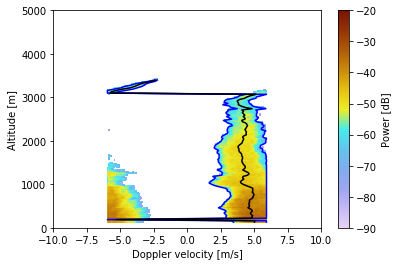

In [325]:
fig, ax = plt.subplots(1,1)
X, Y = np.meshgrid(velocity_bins, spec_range)
plt.pcolormesh(X, Y, the_spectra, vmin=-90, vmax=-20, cmap='pyart_LangRainbow12')
plt.colorbar(ax=ax, label='Power [dB]')
left = np.zeros(len(left_limit))
right = np.zeros(len(right_limit))
i = 0
for l in left_limit:
    if(l > -1):
        left[i] = velocity_bins[int(l)] 
    else:
        left[i] = np.nan
    i = i + 1

i = 0
for l in right_limit:
    if(l > -1):
        right[i] = velocity_bins[int(l)] 
    else:
        right[i] = np.nan
    i = i + 1
    
ax.plot([-6,6], [noise_floor, noise_floor])
ax.plot(left, spec_range, color='b')
ax.plot(right, spec_range, color='b')
ax.plot(np.array(mean_vel), spec_range, color='k')
ax.set_xlim([-10, 10])
ax.set_xlabel('Doppler velocity [m/s]')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([0, 5000])

Plot a profile of mean reflectivity for one time period

C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-07-09 14:42:43.739000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


Text(0,0.5,'Altitide [m]')

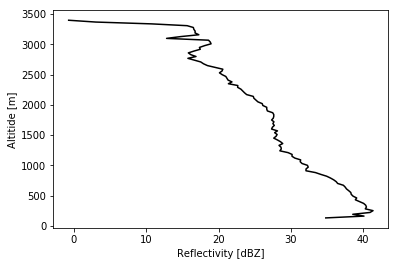

In [326]:
mean_ref = [get_reflectivity(the_spectra[i], velocity_bins, wavelength, left_limit[i], right_limit[i]) 
                for i in range(len(spec_range))]
plt.plot(np.array(mean_ref), spec_range, color='k')
plt.xlabel('Reflectivity [dBZ]')
plt.ylabel('Altitide [m]')

## Dealiasing

C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-07-09 15:02:22.102000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\ipykernel\__main__.py:81: RuntimeWarning: invalid value encountered in greater
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\ipykernel\__main__.py:58: RuntimeWarning: divide by zero encountered in log10
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\ipykernel\__main__.py:71: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\ipykernel\__main__.py:122: RuntimeWarning: invalid value encountered in less


(0, 5000)

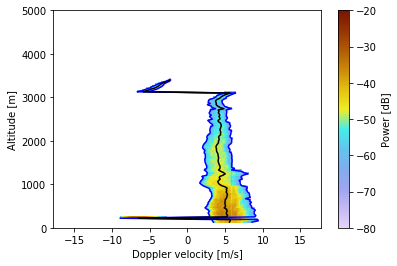

In [354]:
dealiased_spectra, dealiased_bins = dealias_spectra(
    the_spectra, velocity_bins, wavelength, left_limit, right_limit)
left_limit_d, right_limit_d, dealiased_spectra = get_limits_dealiased_spectra(dealiased_spectra)

X, Y = np.meshgrid(dealiased_bins, spec_range)
fig, ax = plt.subplots(1,1)

# Get the mean velocity as a function of range
mean_vel_dealiased = [get_mean_velocity(
    dealiased_spectra[i], dealiased_bins, wavelength, left_limit_d[i], right_limit_d[i]) 
                for i in range(len(spec_range))]
plt.pcolormesh(X, Y, dealiased_spectra, vmin=-80, vmax=-20, cmap='pyart_LangRainbow12')
plt.colorbar(ax=ax, label='Power [dB]')

left = np.zeros(len(left_limit_d))
right = np.zeros(len(right_limit_d))
i = 0
for l in left_limit_d:
    if(l > -1):
        left[i] = dealiased_bins[int(l)] 
    else:
        left[i] = np.nan
    i = i + 1

i = 0
for l in right_limit_d:
    if(l > -1):
        right[i] = dealiased_bins[int(l)] 
    else:
        right[i] = np.nan
    i = i + 1
    
ax.plot([-6,6], [noise_floor, noise_floor])
ax.plot(left, spec_range, color='b')
ax.plot(right, spec_range, color='b')
ax.plot(np.array(mean_vel_dealiased), spec_range, color='k')
ax.set_xlabel('Doppler velocity [m/s]')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([0, 5000])

## Spectral width

C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-07-09 15:02:28.070000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


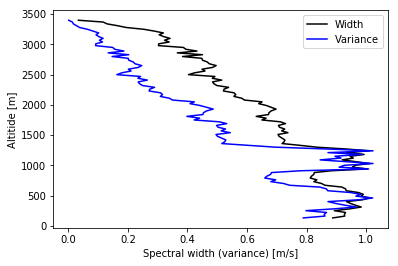

In [355]:
# Use on dealiased spectra!
def spectral_width(spectra, bins, wavelength, left, right):
    if(np.isnan(left) or np.isnan(right)):
        return np.nan
    ref = 10**(get_reflectivity(spectra, bins, wavelength, left, right)/10)
    spectra_linear = 10**(spectra/10)
    radar_constant = 1e18*wavelength**4/(0.93*np.pi**5)
    spec_med = radar_constant*(spectra_linear[:-1]+spectra_linear[1:])/2
    above_floor = np.arange(left, right, 1, dtype='int')
    diffs = np.diff(bins)
    bins_med = (bins[:-1]+bins[1:])/2.0
    mean_vel = get_mean_velocity(spectra, bins, wavelength, left, right) 
    spec_wid = np.nansum(spec_med[above_floor]*(bins_med[above_floor]-mean_vel)**2*diffs[above_floor])/ref
    return np.sqrt(spec_wid)

spec_width = [spectral_width(
    dealiased_spectra[i], dealiased_bins, wavelength, left_limit_d[i], right_limit_d[i]) 
                for i in range(len(spec_range))]
variance = np.array(spec_width)**2

plt.plot(np.array(spec_width), spec_range, color='k')
plt.plot(np.array(variance), spec_range, color='b')
plt.xlabel('Spectral width (variance) [m/s]')
plt.ylabel('Altitide [m]')
plt.legend(['Width', 'Variance'])

## Skewness, Kurtosis

In [356]:
# Use on dealiased spectra!
def skewness(spectra, bins, wavelength, left, right):
    if(np.isnan(left) or np.isnan(right)):
        return np.nan
    ref = 10**(get_reflectivity(spectra, bins, wavelength, left, right)/10)
    spectra_linear = 10**(spectra/10)
    radar_constant = 1e18*wavelength**4/(0.93*np.pi**5)
    spec_med = radar_constant*(spectra_linear[:-1]+spectra_linear[1:])/2
    above_floor = np.where(np.isfinite(spec_med))[0]
    diffs = np.diff(bins)
    bins_med = (bins[:-1]+bins[1:])/2.0
    mean_vel = get_mean_velocity(spectra, bins, wavelength, left, right) 
    spec_width = spectral_width(spectra, bins, wavelength, left, right)
    skew = np.nansum(spec_med[above_floor]*(bins_med[above_floor]-mean_vel)**3*diffs[above_floor])/ref
    return skew/spec_width**3

# Use on dealiased spectra!
def kurtosis(spectra, bins, wavelength, left, right):
    if(np.isnan(left) or np.isnan(right)):
        return np.nan
    ref = 10**(get_reflectivity(spectra, bins, wavelength, left, right)/10)
    spectra_linear = 10**(spectra/10)
    radar_constant = 1e18*wavelength**4/(0.93*np.pi**5)
    spec_med = radar_constant*(spectra_linear[:-1]+spectra_linear[1:])/2
    above_floor = np.where(np.isfinite(spec_med))[0]
    diffs = np.diff(bins)
    bins_med = (bins[:-1]+bins[1:])/2.0
    mean_vel = get_mean_velocity(spectra, bins, wavelength, left, right) 
    spec_width = spectral_width(spectra, bins, wavelength, left, right)
    skew = np.nansum(spec_med[above_floor]*(bins_med[above_floor]-mean_vel)**4*diffs[above_floor])/ref
    return skew/spec_width**4

C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-07-09 15:02:33.361000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-07-09 15:02:34.474000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


Text(0,0.5,'Altitide [m]')

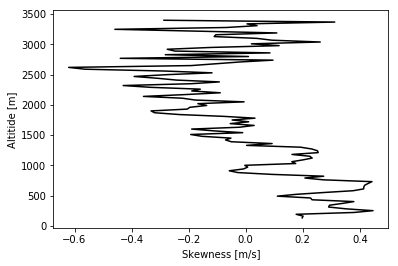

In [357]:
skew = [skewness(dealiased_spectra[i], dealiased_bins, wavelength, left_limit_d[i], right_limit_d[i]) 
                for i in range(len(spec_range))]
kurt = [kurtosis(dealiased_spectra[i], dealiased_bins, wavelength, left_limit_d[i], right_limit_d[i]) 
                for i in range(len(spec_range))]

plt.plot(np.array(skew), spec_range, color='k')
#plt.plot(np.array(kurt), spec_range, color='b')
plt.xlabel('Skewness [m/s]')
plt.ylabel('Altitude [m]')

C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-07-09 15:02:38.957000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


Text(0,0.5,'Altitide [m]')

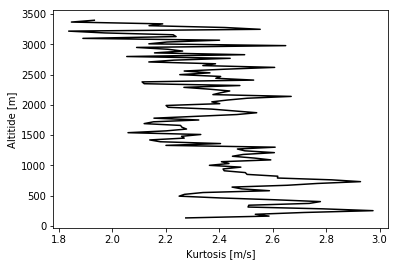

In [358]:
plt.plot(np.array(kurt), spec_range, color='k')
#plt.plot(np.array(kurt), spec_range, color='b')
plt.xlabel('Kurtosis [m/s]')
plt.ylabel('Altitude [m]')


## Do timeseries plot into VPT

In [468]:
# Note: You should only specify a small time period as otherwise the file will be very large!
def spectra_into_vpt(spectra_ds, start_time, end_time):
    # We want: left, right limits, reflectivity, velocity, spectral width, skewness, kurtosis
    # First, we get the times
    times = [(datetime.timedelta(seconds=sec) + 
              datetime.datetime.utcfromtimestamp(spectra_ds.base_time.values.astype("O")/1e9))
             for sec in spectra_ds.time_offset.values]
    times = np.array(times)
    start_ind = np.argmin(np.abs(times-start_time))
    end_ind = np.argmin(np.abs(times-end_time))
    rng = np.squeeze(spectra_ds.range.values)
    times = times[start_ind:end_ind]
    # First, just store the dealiased spectra
    
    left_lim = np.zeros((len(times), len(rng)))
    right_lim = np.zeros((len(times), len(rng)))
    ref = np.zeros((len(times), len(rng)))
    vel = np.zeros((len(times), len(rng)))
    spec_width = np.zeros((len(times), len(rng)))
    skew = np.zeros((len(times), len(rng)))
    kurt = np.zeros((len(times), len(rng)))

    
    for i in range(start_ind, end_ind):
        # Get the raw spectra, bins, and wavelength
        the_spectra = get_spectra(spectra_ds, time=i)
        velocity_bins = spectra_ds.velocity_bins.values
        spec_range = spectra_ds.range.values
        c = 299792458
        wavelength = c/float(spectra_ds.radar_operating_frequency.split(" ")[1])*1e-9

        # Subtract the noise floor from the spectra. Also, return the integration limits
        noise_floor, left_limit, right_limit, the_spectra = get_noise_floor_and_limits(the_spectra,
                                                                                      avg_window=5)
        raw_spectra = get_spectra(spectra_ds, time=i)
        d_spec, dealiased_bins = dealias_spectra(the_spectra, velocity_bins, wavelength, left_limit, right_limit)
        left_lim[i], right_lim[i], d_spectra = get_limits_dealiased_spectra(d_spec)
        del raw_spectra
        ref[i] = np.array([get_reflectivity(
            d_spectra[j], dealiased_bins, wavelength, left_lim[i,j], right_lim[i,j]) 
                for j in range(len(spec_range))])
        vel[i] = np.array([get_mean_velocity(
            d_spectra[j], dealiased_bins, wavelength, left_lim[i,j], right_lim[i,j]) 
                for j in range(len(spec_range))])
        spec_width[i] = np.array([spectral_width(
            d_spectra[j], dealiased_bins, wavelength, left_lim[i,j], right_lim[i,j]) 
                for j in range(len(spec_range))])
        skew[i] = np.array([skewness(
            d_spectra[j], dealiased_bins, wavelength, left_lim[i,j], right_lim[i,j]) 
                for j in range(len(spec_range))])
        kurt[i] = np.array([kurtosis(
            d_spectra[j], dealiased_bins, wavelength, left_lim[i,j], right_lim[i,j]) 
                for j in range(len(spec_range))])
    
    elevation_dic = {'data': [90.0*np.ones(len(times))]}
    base_time = ('seconds since ' + datetime.datetime.strftime(times[0], '%Y-%m-%DT%H:%M:%SZ')) 
    time_dic = {'data': [(x-times[0]).seconds for x in times], 
                'units': base_time,
                'standard_time': 'time',
                'long_name': 'time_in_seconds_since_volume_start'}
    ref_field = {'data': ref, 'standard_name': 'reflectivity', 'units': 'dBZ'}
    vel_field = {'data': vel, 
                 'standard_name': 'mean_velocity_of_scatters_away_from_instrument', 
                 'units': 'm/s'}
    spc_field = {'data': spec_width, 
                 'standard_name': 'spectral_width', 
                 'units': 'm/s'}
    skew_field = {'data': skew, 
                 'standard_name': 'skewness', 
                 'units': ''}
    kurt_field = {'data': kurt, 
                 'standard_name': 'kurtosis', 
                 'units': ''}
    range_field = {'data': rng,
                  'standard_name': 'range',
                  'units': 'm'}
    fields = {'reflectivity': ref, 'velocity': vel_field, 
              'spectral_width': spc_field, 'kurtosis': kurt_field, 
              'skewness': skew_field}
    
    radar = pyart.testing.make_empty_ppi_radar(ngates=len(rng), 
                                               rays_per_sweep=len(times), nsweeps=1)
    radar.add_field('reflectivity', ref_field, replace_existing=True)
    radar.add_field('velocity', vel_field, replace_existing=True)
    radar.add_field('spectral_width', spc_field, replace_existing=True)
    radar.add_field('skewness', skew_field, replace_existing=True)
    radar.add_field('kurtosis', kurt_field, replace_existing=True)
    radar.range = range_field
    pyart.util.to_vpt(radar)
    radar.metadata['instrument_name'] = 'KAZR'
    radar.time['data'] = np.array(time_dic['data'])
    radar.time['units'] = time_dic['units']
    return radar

C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-07-09 16:53:54.682000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [471]:
the_spectra_ds = spectra_into_vpt(spectra_ds, 
                                  datetime.datetime(2011, 5, 20, 13, 0, 0),
                                  datetime.datetime(2011, 5, 20, 13, 10, 0))
the_spectra_ds.info()

C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-07-09 16:54:28.973000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\xarray\coding\variables.py:135: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: invalid value encountered in log10
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\ipykernel\__main__.py:58: RuntimeWarning: divide by zero encountered in log10
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\ipykernel\__main__.py:80: UserWarning: Warn

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float32 and shape: (162,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (162,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	reflectivity:
		data: <ndarray of type: float64 and shape: (162, 582)>
		standard_name: reflectivity
		units: dBZ
	velocity:
		data: <ndarray of type: float64 and shape: (162, 582)>
		standard_name: mean_velocity_of_scatters_away_from_instrument
		units: m/s
	spectral_width:
		data: <ndarray of type: float6

C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-07-09 16:54:29.929000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


(0, 5)

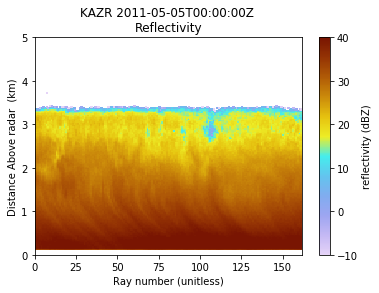

In [472]:
display = pyart.graph.RadarMapDisplay(the_spectra_ds)
display.plot_vpt('reflectivity', vmin=-10, vmax=40, cmap='pyart_LangRainbow12')
plt.ylim([0, 5])

C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-07-09 16:54:31.554000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


(0, 5)

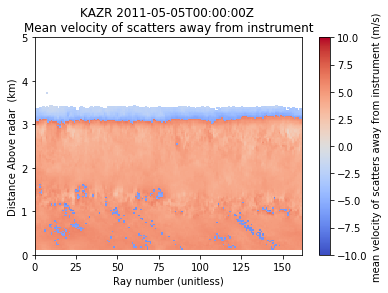

In [473]:
display.plot_vpt('velocity', vmin=-10, vmax=10, cmap='coolwarm')
plt.ylim([0, 5])

C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-07-09 16:57:15.773000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


(0, 5)

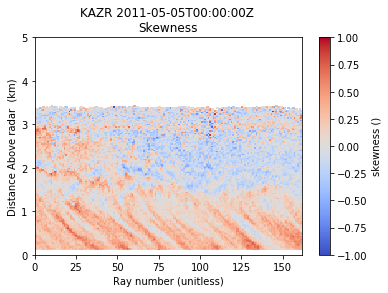

In [476]:
display.plot_vpt('skewness', vmin=-1, vmax=1, cmap='coolwarm')
plt.ylim([0, 5])

C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-07-09 16:57:07.450000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


(0, 5)

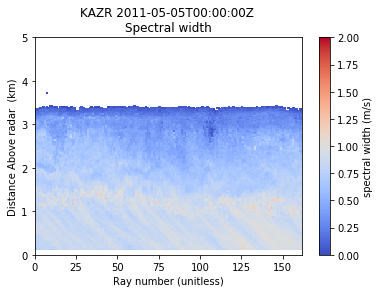

In [475]:
display.plot_vpt('spectral_width', vmin=0, vmax=2, cmap='coolwarm')
plt.ylim([0, 5])